# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [2]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2023-12-07 17:28:45--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2023-12-07 17:28:45--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  36.61M   238MB/s    in 0.2s    

2023-12-07 17:28:45 (238 MB/s) - ‘data.zip’ saved [38392108/38392108]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [3]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights, resnet50
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [4]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # filename = 'data/images/IMG_2383.JPG'
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    # tree = ET.parse('data/xmls/IMG_2383.xml')
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        class_name = class_dict[member.find('name').text]
        for sub_member in member.findall('bndbox'):
          xmin = int(sub_member.find('xmin').text)
          ymin = int(sub_member.find('ymin').text)
          xmax = int(sub_member.find('xmax').text)
          ymax = int(sub_member.find('ymax').text)
        res =  [
            xmin,
            ymin,
            xmax,
            ymax,
            class_name
        ]
        bboxes.append(res)

    return bboxes

# with open('data/class_dict') as f:
#     class_dict = eval(f.readline())
# get_xml_data('IMG_2383.JPG', Path('data/images/'), class_dict=class_dict, xml_prefix='')

In [5]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):
        ### YOUR CODE HERE ###

        fname = self.filenames[idx]
        image = np.array(Image.open(fname))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def get_size(self, idx):
      fname = self.filenames[idx]
      fname = fname.replace('images', 'xmls')
      xml = fname.replace('JPG', 'xml')
      xml = xml.replace('jpg', 'xml')

      tree = ET.parse(xml)
      treeroot = tree.getroot()
      size = []
      for member in treeroot.findall('size'):
        size.append(int(member.find('width').text))
        size.append(int(member.find('height').text))
      return size



    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        ### YOUR CODE HERE ###

        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [6]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [7]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [8]:
def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break
        # Вот тут нужно выполнить permute (вспомните где у torch каналы, а где они у matplotlib)
        # И откатить нормализацию (просто обратное преобразование)
        # Имена и количества классов можно подтянуть из датасета через train_ds.class_dict_inv
        image = images[i]

        def inverse_normalize(tensor, mean, std):
          for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
          return tensor

        image_inv = inverse_normalize(tensor=image, mean=mean, std=std).permute(1, 2, 0)

        ax.imshow(image_inv)
        for bbox in bboxes[i]:
        # ### YOUR CODE HERE ###
          bbox_tensor = torch.Tensor(bbox).int()
          # bbox_tensor[0] = int(bbox_tensor[0] * train_ds.get_size(i)[0] / 512)
          # bbox_tensor[1] = int(bbox_tensor[1] * train_ds.get_size(i)[1] / 512)
          # bbox_tensor[2] = int(bbox_tensor[2] * train_ds.get_size(i)[0] / 512)
          # bbox_tensor[3] = int(bbox_tensor[3] * train_ds.get_size(i)[1] / 512)

          p = Rectangle((bbox_tensor[0], bbox_tensor[1]), bbox_tensor[2] - bbox_tensor[0], bbox_tensor[3] - bbox_tensor[1], fill=False)
          ax.text(int((bbox_tensor[0] + bbox_tensor[2]) / 2), bbox_tensor[1] - 15,
                  list(train_ds.class_dict_inv.values())[bbox[4]])

          ax.add_patch(p)




    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

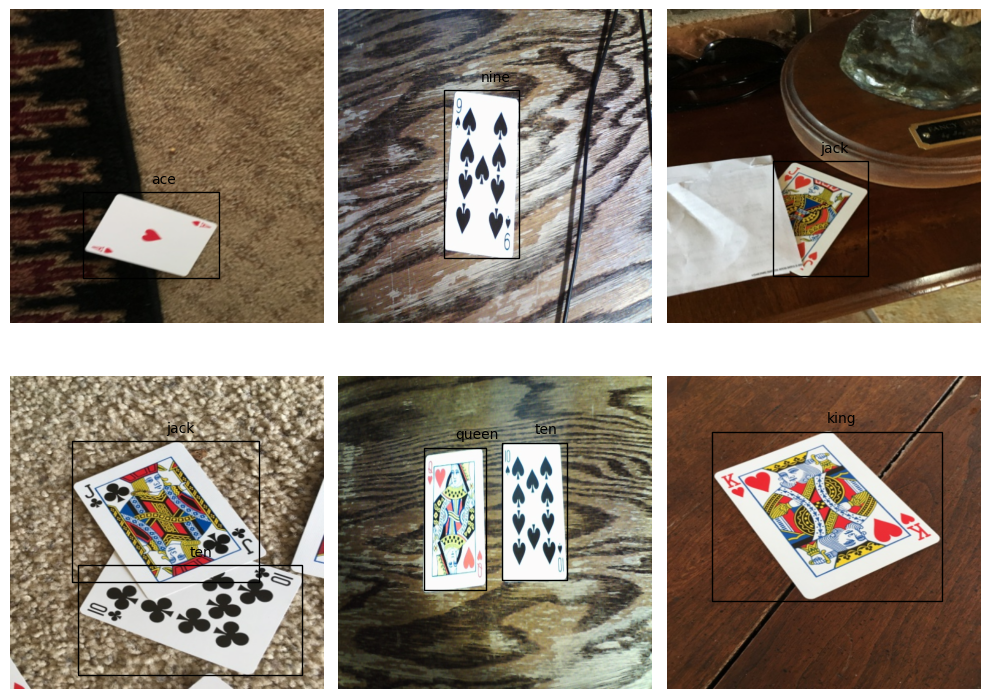

In [9]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [10]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell =  32
        y_cell =  32
        w_box =  (xmax - xmin) / w
        h_box =  (ymax - ymin) / h

        # Посчитайте координаты центра и сдвиги
        cx =  (xmax + xmin) / 2
        cy =  (ymax + ymin) / 2
        cx_idx = (cx // x_cell).to(torch.long)
        cy_idx = (cy // y_cell).to(torch.long)
        cx_box =  cx - cx_idx * x_cell
        cy_box =  cy - cy_idx * y_cell


        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

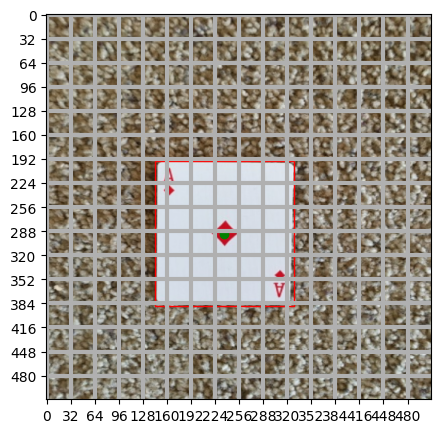

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [12]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    ### YOUR CODE HERE ###
    rectangles = []
    for batch_idx in range(b):
        sub_rectangles = []
        for i in range(h):
            for j in range(w):
                if pred[batch_idx, 4, i, j] > threshold:  # если вероятность класса выше порога
                    # вычисляем координаты прямоугольника
                    x1 = j * upsample
                    y1 = i * upsample
                    x2 = (j + 1) * upsample
                    y2 = (i + 1) * upsample

                    class_idx = pred[batch_idx, 5, i, j]

                    sub_rectangles.append((float(x1), float(y1), float(x2), float(y2), int(class_idx)))
        rectangles.append(sub_rectangles)

    return rectangles

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [13]:
C = 6
from torchvision.models.resnet import Bottleneck


class Detector(nn.Module):
    def __init__(self, num_classes=6):
        super(Detector, self).__init__()
        self.resnet = resnet50(weights=ResNet50_Weights)  # Используем ResNet50 до layer4

        self.additional_blocks = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 5 + C, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, img):
        x = self.resnet.conv1(img)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.additional_blocks(x)

        return x

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [14]:
import torch.nn.functional as F

def special_loss(pred, target, check=False, C=1):
    mask = (target == 1)
    noobj_mask = (target == 0)
    # Функция потерь для локализации
    pred_xy = pred[:, :2, :, :]
    target_xy = target[:, :2, :, :]
    localization_loss = F.mse_loss(
        torch.masked_select(pred_xy, mask[:, :2, :, :]),
        torch.masked_select(target_xy, mask[:, :2, :, :]),
        reduction='sum'
        )

    # Функция потерь для размеров коробки
    pred_wh = pred[:, 2:4, :, :]
    target_wh = target[:, 2:4, :, :]
    box_loss = F.mse_loss(
        torch.masked_select(pred_wh, mask[:, 2:4, :, :]),
        torch.masked_select(target_wh, mask[:, 2:4, :, :]),
        reduction='sum')
    # Функция потерь для классификации

    pred_class = torch.argmax(pred[:, 5:, :, :], dim=1).float()
    target_class = target[:, 5, :, :]
    classification_loss = F.binary_cross_entropy_with_logits(
        torch.masked_select(pred_class, mask[:, 5, :, :]),
        torch.masked_select(target_class, mask[:, 5, :, :]),
        reduction='sum'
    )

    # Функция потерь для уверенности
    confidence_loss_detect = F.binary_cross_entropy_with_logits(
        pred[:, 4, :, :], mask[:, 4, :, :].float(),
        reduction='sum'
        )
    confidence_loss_nondetect = F.binary_cross_entropy_with_logits(
        pred[:, 4, :, :], noobj_mask[:, 4, :, :].float(),
        reduction='sum'
        )
    confidence_loss = confidence_loss_detect + 0.1 * confidence_loss_nondetect

    if not check:
        return 10 * localization_loss + box_loss + classification_loss + confidence_loss
    else:
        return localization_loss, box_loss, classification_loss, confidence_loss


In [14]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 11, 16, 16)), torch.ones((10, 6, 16, 16)), check=True, C=6) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

AssertionError: ignored

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [15]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS = 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        ### YOUR CODE HERE ###

        inputs = batch['image'].to(device)
        labels = batch['target'].to(device)

        # Forward pass
        outputs = model(inputs)


        # Compute loss
        loss = special_loss(outputs, labels)

        # Backward pass and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Update progress bar and epoch losses
        pbar.set_postfix({"loss": loss.item()})
        epoch_losses.append(loss.item())


    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 0 done; Train loss 2122.779;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 done; Train loss 1947.842;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 done; Train loss 1936.463;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 done; Train loss 1933.317;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 done; Train loss 1931.769;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 done; Train loss 1930.863;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 done; Train loss 1930.295;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 done; Train loss 1929.896;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 done; Train loss 1929.619;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 done; Train loss 1929.404;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 done; Train loss 1929.243;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 11 done; Train loss 1929.118;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 12 done; Train loss 1929.017;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 13 done; Train loss 1928.941;


  0%|          | 0/33 [00:00<?, ?it/s]

Epoch 14 done; Train loss 1928.866;


Запустим обученный детектор на тестовых изображениях:

In [17]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [20]:
# Нужно сделать предсказание и переложить результат на cpu

### YOUR CODE HERE ###

outputs = model(batch['image'].to(device))
decoded_preds = decode_prediction(outputs, threshold=0.001)
print(decoded_preds)

[[(0.0, 0.0, 32.0, 32.0, 0), (480.0, 0.0, 512.0, 32.0, 0), (0.0, 480.0, 32.0, 512.0, 0), (480.0, 480.0, 512.0, 512.0, 0)], [(0.0, 0.0, 32.0, 32.0, 0), (480.0, 0.0, 512.0, 32.0, 0), (0.0, 480.0, 32.0, 512.0, 0), (480.0, 480.0, 512.0, 512.0, 0)], [(0.0, 0.0, 32.0, 32.0, 0), (480.0, 0.0, 512.0, 32.0, 0), (0.0, 480.0, 32.0, 512.0, 0), (480.0, 480.0, 512.0, 512.0, 0)], [(0.0, 0.0, 32.0, 32.0, 0), (480.0, 0.0, 512.0, 32.0, 0), (0.0, 480.0, 32.0, 512.0, 0), (480.0, 480.0, 512.0, 512.0, 0)], [(0.0, 0.0, 32.0, 32.0, 0), (480.0, 0.0, 512.0, 32.0, 0), (0.0, 480.0, 32.0, 512.0, 0), (480.0, 480.0, 512.0, 512.0, 0)], [(0.0, 0.0, 32.0, 32.0, 0), (480.0, 0.0, 512.0, 32.0, 0), (0.0, 480.0, 32.0, 512.0, 0), (480.0, 480.0, 512.0, 512.0, 0)]]


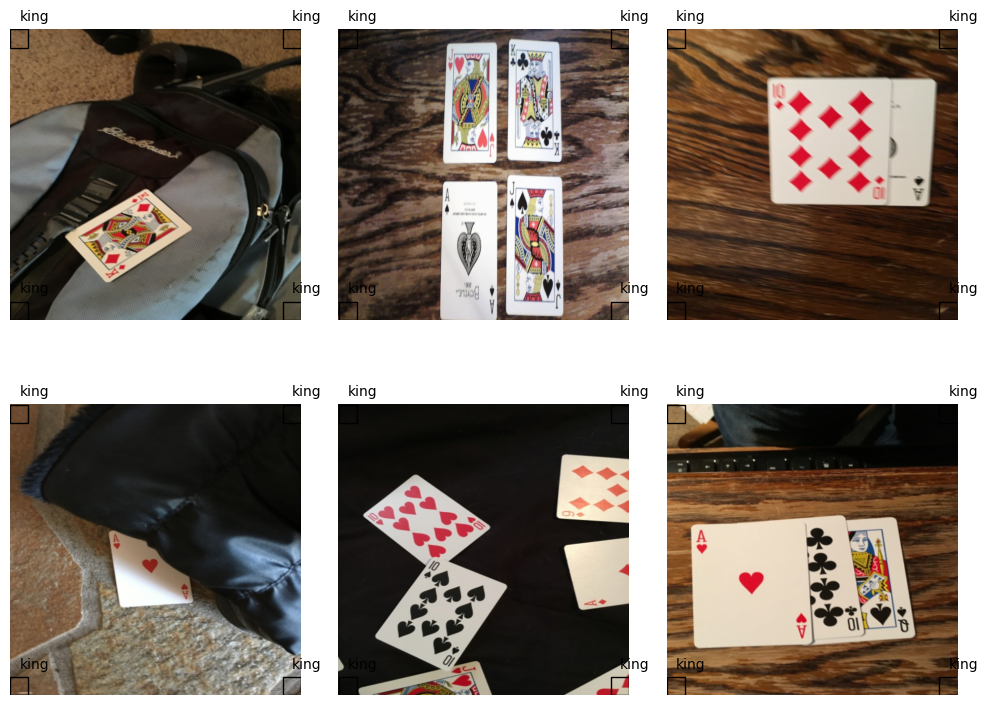

In [21]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1

### YOUR CODE HERE ###


out = [batch['image'][i] for i in range(6)]

visualize([o for o in out], [b for b in decoded_preds])

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [22]:
!pip install ultralytics

## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [17]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [18]:
def annotation2txt(bboxes, w_im, h_im):
    txt_annotations = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max, class_id = bbox
        x_center = (x_min + x_max) / 2.0
        y_center = (y_min + y_max) / 2.0
        width = x_max - x_min
        height = y_max - y_min
        x_center /= w_im
        width /= w_im
        y_center /= h_im
        height /= h_im
        txt_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")
    return txt_annotations

In [19]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [20]:
# Собираем YAML
nc =  6
names =  ['king', 'jack', 'ace', 'ten', 'nine', 'queen']

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [25]:
from ultralytics import YOLO

### YOUR CODE HERE ###
# Load the model.
model = YOLO('yolov8s.pt')

# Training.
results = model.train(
   data='data.yaml',
   imgsz=512,
   epochs=10,
   batch=8,
   name='yolov8s_custom'
  )


100%|██████████| 21.5M/21.5M [00:00<00:00, 186MB/s]


Ultralytics YOLOv8.0.223 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=10, patience=50, batch=8, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8s_custom, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, ke

100%|██████████| 755k/755k [00:00<00:00, 22.6MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 103MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 2047.97it/s]

train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 0 corrupt: 100%|██████████| 37/37 [00:00<00:00, 1422.98it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/yolov8s_custom/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8s_custom
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.53G     0.6166      4.433      1.001         12        512: 100%|██████████| 41/41 [00:08<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.23it/s]

                   all         37         68      0.311      0.648      0.401      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.59G     0.5354      1.855     0.8943         12        512: 100%|██████████| 41/41 [00:05<00:00,  6.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.80it/s]

                   all         37         68      0.376      0.784      0.518       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.59G     0.5643       1.61     0.9164         10        512: 100%|██████████| 41/41 [00:09<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.31it/s]


                   all         37         68       0.43      0.927      0.535      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.59G     0.5683      1.487     0.9094          8        512: 100%|██████████| 41/41 [00:05<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.04it/s]


                   all         37         68      0.526      0.793       0.65      0.587

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.59G     0.5484      1.325     0.8973         11        512: 100%|██████████| 41/41 [00:07<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.80it/s]


                   all         37         68      0.446      0.902      0.597      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.59G     0.5278      1.244     0.8972         14        512: 100%|██████████| 41/41 [00:05<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]

                   all         37         68      0.436      0.952      0.626       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10       1.6G     0.4814      1.103     0.8675         11        512: 100%|██████████| 41/41 [00:07<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.13it/s]

                   all         37         68      0.515      0.879       0.64      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.59G      0.452       1.02     0.8673         13        512: 100%|██████████| 41/41 [00:06<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.08it/s]

                   all         37         68      0.567      0.846      0.723      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10       1.6G      0.425      1.007     0.8479         14        512: 100%|██████████| 41/41 [00:06<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.77it/s]


                   all         37         68      0.587      0.864      0.747      0.685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.59G     0.4042     0.9402     0.8396          8        512: 100%|██████████| 41/41 [00:07<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

                   all         37         68       0.61      0.938      0.785      0.734



10 epochs completed in 0.026 hours.
Optimizer stripped from runs/detect/yolov8s_custom/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/yolov8s_custom/weights/best.pt, 22.5MB

Validating runs/detect/yolov8s_custom/weights/best.pt...
Ultralytics YOLOv8.0.223 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11127906 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.33it/s]


                   all         37         68      0.612      0.938      0.785      0.733
                  king         37         12      0.542          1      0.858      0.803
                  jack         37          8      0.348      0.625       0.33      0.292
                   ace         37         16      0.849          1      0.991      0.919
                   ten         37         11      0.466          1      0.638       0.59
                  nine         37         13      0.535          1      0.894      0.873
                 queen         37          8       0.93          1      0.995      0.921
Speed: 0.8ms preprocess, 5.5ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to runs/detect/yolov8s_custom


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [ ]:
### YOUR CODE HERE ###